In [18]:
import pandas as pd
import numpy as np
import json
from datetime import timedelta, date, datetime

## Import the latest COVID data, cleaned

In [2]:
df= pd.read_csv('../data/interim/cumulative_coviddata.csv', index_col=0, parse_dates=['date'])
df_daily=pd.read_csv('../data/interim/daily_coviddata.csv', index_col=0, parse_dates=['date'])
per100Th_cumulative=pd.read_csv('../data/interim/cumulative_PHT_coviddata.csv', index_col=0, parse_dates=['date'])
per100Th_daily=pd.read_csv('../data/interim/daily_PHT_coviddata.csv', index_col=0, parse_dates=['date'])

In [5]:
countries = sorted(pd.unique(per100Th_daily['Country']))

### Calculate peak deaths per hundred thousand (7 day mean aggregated) all time per country

In [6]:
peak_daily_deaths_PHT=pd.DataFrame()
for country in countries:
    pdd_country_PHT= per100Th_daily[per100Th_daily['Country']==country].set_index(['date']).resample('7D').mean()['deaths'].max()
    df = pd.DataFrame([[country,pdd_country_PHT]],  columns=['Country', 'peak_daily_deaths_PHT'])
    peak_daily_deaths_PHT=pd.concat([peak_daily_deaths_PHT, df])
peak_daily_deaths_PHT

,Country,peak_daily_deaths_PHT
0,Afghanistan,0.229071
0,Albania,0.689269
0,Algeria,0.049441
0,Andorra,2.038169
0,Angola,0.022444
...,...,...
0,Venezuela (Boliv. Rep. of),0.069135
0,Viet Nam,0.029916
0,Yemen,0.047518
0,Zambia,0.336727


In [7]:
#Calculate cumulative deaths since the start (classified as deaths per 100,000 population >0.25)
cumul_deaths_sincestart=pd.DataFrame()
for country in countries:
    cDSS_country= per100Th_cumulative[per100Th_cumulative['Country']==country].set_index(['date']).resample('7D').mean()
    sincestart_df= cDSS_country[cDSS_country['deaths']>0.25]
    totaldays=len(sincestart_df)
    if totaldays>7:
        totaldeaths_PHT=sincestart_df.iloc[-1,:]['deaths']
        deaths_pd_sincestart=totaldeaths_PHT/totaldays
    else:
        totaldeaths_PHT= 0
        deaths_pd_sincestart=0
    df = pd.DataFrame([[country,deaths_pd_sincestart]],  columns=['Country', 'Total deaths/days since start'])
    cumul_deaths_sincestart=pd.concat([cumul_deaths_sincestart, df])
cumul_deaths_sincestart= cumul_deaths_sincestart.sort_values(['Total deaths/days since start'],ascending=False)


In [8]:
cumul_deaths_sincestart.to_csv('../data/interim/cumul_deaths_sincestart.csv')

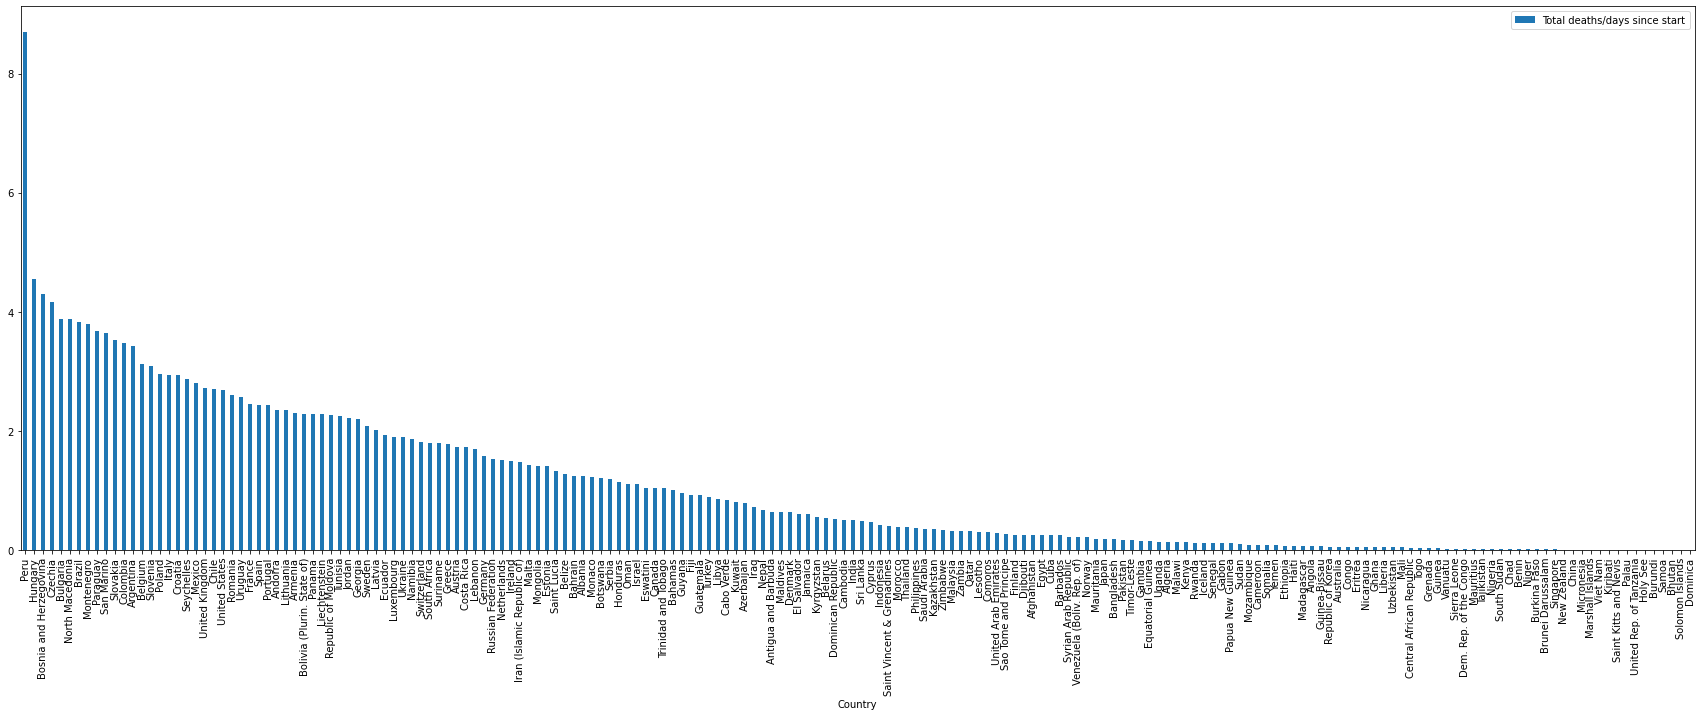

In [9]:

cumul_deaths_sincestart.plot(kind='bar', x='Country', y='Total deaths/days since start', figsize=(30,10));



## Features dataframe with data per country from UN site


In [10]:
url = 'https://data.un.org/_Docs/SYB/CSV/SYB63_1_202105_Population,%20Surface%20Area%20and%20Density.csv'
df_data= pd.read_csv(url, header=1)

In [11]:
# Create features dataframe for countries: population density, Sex ratio (males per 100 females), Population aged 60+ years old (percentage)


In [12]:
#use the population dataframe first, don't want all these population features. Also 2019 only has the population density and population mid-year estimates for San Marino and other small countries

features= pd.unique(df_data.Series)
features

array(['Population mid-year estimates (millions)',
       'Population mid-year estimates for males (millions)',
       'Population mid-year estimates for females (millions)',
       'Sex ratio (males per 100 females)',
       'Population aged 0 to 14 years old (percentage)',
       'Population aged 60+ years old (percentage)', 'Population density',
       'Surface area (thousand km2)'], dtype=object)

In [13]:

#subset all data for one feature, all years
df_all=df_data[df_data['Series']==features[0]][['Unnamed: 1','Value','Year']]
df_all.columns=['Country',features[0],'Year']
df_all 
#for each year show the number of countries with nas for this feature
years=pd.unique(df_all.Year)
count_countries={}
for year in years:
    count_yr=df_data[df_data['Year']==year][['Unnamed: 1','Value']]
    count_yr.columns=['Country',features[0]]
    count_countries[year]=len(count_yr.Country)
best_year=max(count_countries, key=count_countries.get)
df=df_all[df_all['Year']==best_year]
df.drop(columns=['Year'],inplace=True)

/Users/lisacrowther/opt/anaconda3/envs/VIZ/lib/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
features=features[3:]

In [15]:
for feature in range(len(features)):
    new_df=df_data[df_data['Series']==features[feature]][['Unnamed: 1','Value','Year']]
    new_df.columns=['Country',features[feature],'Year']
    count_countries={}
    for year in years:
        count_yr=df_data[df_data['Year']==year][['Unnamed: 1','Value']]
        count_yr.columns=['Country',features[feature]]
        count_countries[year]=len(count_yr.Country)
    best_year=max(count_countries, key=count_countries.get)
    new_df=new_df[new_df['Year']==best_year]
    new_df.columns=['Country',features[feature],'year_{}'.format(features[feature])]
    #comment out if want to keep year used for each feature
    new_df.drop(columns=['year_{}'.format(features[feature])],inplace=True)
    df=df.merge(new_df, on='Country', how='left')
df

,Country,Population mid-year estimates (millions),Sex ratio (males per 100 females),Population aged 0 to 14 years old (percentage),Population aged 60+ years old (percentage),Population density,Surface area (thousand km2)
0,"Total, all countries or areas",7547.8589,101.6855,25.8943,12.7105,58.0185,136162.000
1,Africa,1244.2223,99.7673,40.9200,5.3562,41.9658,30311.000
2,Northern Africa,232.7932,100.9575,32.6786,8.3118,29.9627,7880.000
3,Sub-Saharan Africa,1011.4291,99.4954,42.8168,4.6759,46.2282,22431.000
4,Eastern Africa,411.3967,98.3709,42.9062,4.4561,61.7019,7005.000
...,...,...,...,...,...,...,...
254,Wallis and Futuna Islands,0.0118,NaN,NaN,NaN,84.0929,0.142
255,Western Sahara,0.5526,110.1445,28.0562,5.3980,2.0775,266.000
256,Yemen,27.8348,101.5918,40.0014,4.4870,52.7205,527.968
257,Zambia,16.8536,98.0250,45.4114,3.3133,22.6713,752.612


In [19]:
# Paths to data per country
GDP_datapath='https://data.un.org/_Docs/SYB/CSV/SYB63_230_202009_GDP%20and%20GDP%20Per%20Capita.csv'
education_datapath='https://data.un.org/_Docs/SYB/CSV/SYB63_309_202009_Education.csv'
healthcare_datapath='https://data.un.org/_Docs/SYB/CSV/SYB63_154_202105_Health%20Personnel.csv'
RnDstaff_datapath= 'https://data.un.org/_Docs/SYB/CSV/SYB63_285_202009_Research%20and%20Development%20Staff.csv'
RnDspending_datapath='https://data.un.org/_Docs/SYB/CSV/SYB63_286_202009_GDP%20on%20R&D.csv'
sanitation_datapath='https://data.un.org/_Docs/SYB/CSV/SYB63_315_202009_Water%20and%20Sanitation%20Services.csv'
land_datapath='https://data.un.org/_Docs/SYB/CSV/SYB63_145_202009_Land.csv'
internetusage_datapath='https://data.un.org/_Docs/SYB/CSV/SYB63_314_202009_Internet%20Usage.csv'
paths=[GDP_datapath,education_datapath,healthcare_datapath,RnDstaff_datapath,RnDspending_datapath,sanitation_datapath,internetusage_datapath]

# Load the name-change json file for data per country
with open('../data/interim/country_namechanges.json', 'r') as fp:
    new_names = json.load(fp)
new_names['US']='United States'
new_names['United States of America']='United States'

In [20]:
#load the data from each path and change country names to be consistent, from the country_namechanges.json file created in cleaning data step)
for path in paths:
    df_data= pd.read_csv(path, header=1) 
    for name in new_names:
        df_data.replace(to_replace=name, value=new_names[name], inplace=True)
    features= pd.unique(df_data.Series)
    for feature in range(len(features)):
        new_df=df_data[df_data['Series']==features[feature]][['Unnamed: 1','Value','Year']]
        new_df.columns=['Country',features[feature],'Year']
        count_countries={}
        for year in years:
            count_yr=df_data[df_data['Year']==year][['Unnamed: 1','Value']]
            count_yr.columns=['Country',features[feature]]
            count_countries[year]=len(count_yr.Country)
        best_year=max(count_countries, key=count_countries.get)
        new_df=new_df[new_df['Year']==best_year]
        new_df.columns=['Country',features[feature],'year_{}'.format(features[feature])]
        #comment out if want to keep year used for each feature
        new_df.drop(columns=['year_{}'.format(features[feature])],inplace=True)
        df=df.merge(new_df, on='Country', how='left')
df

,Country,Population mid-year estimates (millions),Sex ratio (males per 100 females),Population aged 0 to 14 years old (percentage),Population aged 60+ years old (percentage),Population density,Surface area (thousand km2),GDP in current prices (millions of US dollars),GDP per capita (US dollars),GDP in constant 2010 prices (millions of US dollars),...,Gross domestic expenditure on R & D: Funds from abroad (%),Gross domestic expenditure on R & D: Not distributed (%),Gross domestic expenditure on R & D: Private non-profit (%),"Safely managed drinking water sources, urban (Proportion of population with access)","Safely managed drinking water sources, rural (Proportion of population with access)","Safely managed drinking water sources, total (Proportion of population with access)","Safely managed sanitation facilities, urban (Proportion of population with access)","Safely managed sanitation facilities, rural (Proportion of population with access)","Safely managed sanitation facilities, total (Proportion of population with access)",Percentage of individuals using the internet
0,"Total, all countries or areas",7547.8589,101.6855,25.8943,12.7105,58.0185,136162.000,6.623183e+07,9522.7233,6.469916e+07,...,NaN,NaN,NaN,85.8733,45.7852,66.4963,41.2881,32.5330,37.0562,28.7084
1,Africa,1244.2223,99.7673,40.9200,5.3562,41.9658,30311.000,1.968455e+06,1896.7958,2.022419e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Northern Africa,232.7932,100.9575,32.6786,8.3118,29.9627,7880.000,6.487266e+05,3204.2212,7.641700e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,35.6687,NaN,23.7565,24.5691
3,Sub-Saharan Africa,1011.4291,99.4954,42.8168,4.6759,46.2282,22431.000,1.319729e+06,1579.9093,1.258249e+06,...,NaN,NaN,NaN,46.0458,8.9419,22.3545,19.0923,16.1067,17.1860,6.5452
4,Eastern Africa,411.3967,98.3709,42.9062,4.4561,61.7019,7005.000,2.178597e+05,644.0245,2.411793e+05,...,NaN,NaN,NaN,45.5973,5.8028,15.4942,NaN,NaN,NaN,4.4616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,Wallis and Futuna Islands,0.0118,NaN,NaN,NaN,84.0929,0.142,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.1600
255,Western Sahara,0.5526,110.1445,28.0562,5.3980,2.0775,266.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256,Yemen,27.8348,101.5918,40.0014,4.4870,52.7205,527.968,3.090675e+04,1334.7849,4.771259e+04,...,NaN,NaN,NaN,NaN,NaN,NaN,67.3811,NaN,NaN,12.3500
257,Zambia,16.8536,98.0250,45.4114,3.3133,22.6713,752.612,2.026540e+04,1489.4476,1.622206e+04,...,NaN,NaN,NaN,47.0679,NaN,NaN,NaN,NaN,NaN,10.0000


In [21]:
#some features are missing from some countries. Count how many countries are missing each feature

In [22]:
pd.DataFrame({'feature': df.isna().sum().index,'Count: values missing':  df.isna().sum().values})
          

,feature,Count: values missing
0,Country,0
1,Population mid-year estimates (millions),0
2,Sex ratio (males per 100 females),29
3,Population aged 0 to 14 years old (percentage),29
4,Population aged 60+ years old (percentage),29
5,Population density,0
6,Surface area (thousand km2),0
7,GDP in current prices (millions of US dollars),22
8,GDP per capita (US dollars),22
9,GDP in constant 2010 prices (millions of US do...,22


In [23]:
df_features= df.merge(cumul_deaths_sincestart, on='Country', how='outer')
df_features.dropna(subset=['Total deaths/days since start'], inplace=True)
df_features=df_features[df_features['Total deaths/days since start']>0]

In [24]:
np.setdiff1d(np.unique(df_all.Country),np.unique(cumul_deaths_sincestart.Country))
df_features.drop(columns=['Population mid-year estimates (millions)'],inplace=True)

In [25]:
df_features = df_features.drop(df_features.filter(regex=('number')).columns, axis=1)
df_features = df_features.drop(df_features.filter(regex=('thousands')).columns, axis=1)

In [26]:
df_features.columns
#remove features not adjusted for population (anything with 'numbers' or 'thousands' in the name)

Index(['Country', 'Sex ratio (males per 100 females)',
       'Population aged 0 to 14 years old (percentage)',
       'Population aged 60+ years old (percentage)', 'Population density',
       'Surface area (thousand km2)',
       'GDP in current prices (millions of US dollars)',
       'GDP per capita (US dollars)',
       'GDP in constant 2010 prices (millions of US dollars)',
       'GDP real rates of growth (percent)',
       'Gross enrollment ratio - Primary (male)',
       'Gross enrollment ratio - Primary (female)',
       'Gross enrollment ratio - Secondary (male)',
       'Gross enrollment ratio - Secondary (female)',
       'Gross enrollment ratio - Tertiary (male)',
       'Gross enrollment ratio - Tertiary (female)',
       'Health personnel: Physicians (per 1000 population)',
       'Health personnel: Pharmacists (per 1000 population)',
       'Health personnel: Nurses and midwives personnel (per 1000 population)',
       'Health personnel: Dentists (per 1000 population)'

In [30]:
df_features.to_csv('../data/interim/df_features_COVID.csv', index=True)